# Demo v1



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls "/content/drive/My Drive/imagesv2/"


Dump_output		      out1.pdf_left_skewed_10.jpg
Extracted_csv		      out1.pdf_right_skewed8.JPG
out1.pdf_180+rot+scaled.jpg   out1.pdf_rot+scaled.jpg
out1.pdf_90+white_border.jpg  out1.pdf_scaled_80.jpg
out1.pdf_border_black.jpg     out1.pdf_yellowed.jpg


# Installing Tesseract & Vision API




In [0]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install google-cloud-vision

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


# Importing Libraries

In [0]:
import cv2
import pytesseract
import re
import numpy as np
from pytesseract.pytesseract import TesseractError
import io
from google.cloud import vision


# Pre-Processing Functions


In [0]:
def detect_orientation(image):
    """ Returns correct oriented image
    :param image: Input image
    """
    custom_oem_psm_config = r'--oem 1--psm 7'
    newdata = pytesseract.image_to_osd(image,config= custom_oem_psm_config)
    rotation = int(re.search('(?<=Rotate: )\\d+', newdata).group(0))
    # print("Rotation degrees : ", rotation)
    return rotate_img(image, rotation)


def rotate_img(image, degrees):
    """Returns image rotated to the angle provided by detect_orientation
    :param image: The input image
    :param degrees: Angle to rotate
    :return Corrected image
    """
    if degrees == 90:
        return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    elif degrees == 180:
        return cv2.rotate(image, cv2.ROTATE_180)
    elif degrees == 270:
        return cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif degrees == 0:
        return image
    else:
        print("DEGREE = ", degrees)

def straighten(image):
    """Applies straighten to an image
    :param image : Input image
    :return Straightened image
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    # print("Straightening angle : ", angle)
    return rotated

def straighten_thresh(image):
    """Applies straighten to an image
    :param image : Input threshold image
    :return Straightened image
    """
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    # print("Straightening angle : ", angle)
    return rotated

def extract_image(image):
  """
  Returns borderless image
  :param image : Image with border
  :returns borderless image
  """
  img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  re, img = cv2.threshold(img,160, 255, cv2.THRESH_BINARY)
  cont, hier = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  area = 0
  biggest_cont = cont[0][0]
  peri = cv2.approxPolyDP(cont[0][0], 0.1, False)

  for i in cont:
      area1 = cv2.contourArea(i)
      if area1 > area:
          peri = cv2.approxPolyDP(i, 0.1, True)
          area = area1
          biggest_cont = i

  mask = np.zeros((image.shape[0], image.shape[1]),dtype=np.uint8)
  cv2.drawContours(mask, [biggest_cont], -1,(255,255,255),thickness=0)
  sub_image = img - mask
  st_sub_images = straighten_thresh(sub_image)
  thresh = cv2.threshold(st_sub_images,1,255,cv2.THRESH_BINARY)[1]
  contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  if len(contours) == 1:
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    st_sub_images = st_sub_images[y:y+h,x:x+w]
  return st_sub_images

def plot_before_after(before, after):
    """
    :param before: Before correction image
    :param after: After correction image
    """
    import matplotlib.pyplot as plt
    plt.figure(figsize=(16, 22))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    plt.grid(True)
    plt.title(label="Before : ")

    plt.subplot(1, 2, 2)
    plt.imshow(after, cmap='Greys_r')
    # plt.axis('off')
    plt.grid(True)
    plt.title(label='After : ')
    plt.show()

def detect_border_color(img):
    # img = cv2.threshold((cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)),127,255,cv2.THRESH_BINARY)[1]
    l,b = img.shape
    PERCENTAGE = 3
    l = (l*PERCENTAGE)//100
    b = (b*PERCENTAGE)//100
    # print(l,b)
    c1 = img[:,:b]
    c2 = img[:l,:]
    # display(c1)
    # display(c2)
    values1, counts1 = np.unique(c1, return_counts=True)
    values2, counts2 = np.unique(c2, return_counts=True)
    if values1[np.argmax(counts1)] == values2[np.argmax(counts2)]:
        # print(type(values1[np.argmax(counts1)]))
        return values1[np.argmax(counts1)]
    else:
        print("Extra space exists")
        return None

def cropped(img_gray,value):
    # img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # img_gray = cv2.threshold(img_gray,127,255,type = cv2.THRESH_BINARY)[1]
    # print(type(img_gray),img_gray.shape)
    # print(img_gray)
    # display(img_gray,0.35,0.35)
    cont_x = [i for i in range(img_gray.shape[0]) if set(img_gray[i]) != {value}]
    first_x,last_x =cont_x[0],cont_x[-1]

    img_gray_trans = np.transpose(img_gray)
    cont_y = [i for i in range(img_gray_trans.shape[0]) if set(img_gray_trans[i]) != {value}]
    first_y,last_y =cont_y[0],cont_y[-1]

    img_cropped : np.ndarray = img_gray[first_x:last_x,first_y:last_y]
    # print(img_cropped.shape)
    return img_cropped
   

def preprocess(PATH):
    print('='*40+'\tPreprocessing\t'+'='*40)
    # print(PATH)
    # print(os.getcwd())
    image_org = cv2.imread(PATH)
    image = np.copy(image_org)
    flag = False
    try:
        image = detect_orientation(image)
    except TesseractError as e:
        # print('Exception handled')
        flag = True
    image = straighten(image)
    image = extract_image(image)  # GENERATES BINARY IMAGE
    # scripts.preprocessing.display(image,0.35,0.35)
    if flag:
        image = detect_orientation(image)
        image = straighten_thresh(image)

    ### EXTRA SPACE REMOVAL ###
    value = detect_border_color(image)
    if value:
        image = cropped(image, value)
    plot_before_after(image_org, image)
    return image

# Entity Extraction

In [0]:
def image_to_desciption_text(image_path):
    with io.open(image_path, 'rb') as image_file:
        content = image_file.read()
    client = vision.ImageAnnotatorClient()
    image = vision.types.Image(content = content)
    response = client.text_detection(image=image)
    return response.text_annotations[0].description


In [0]:
def extract_fields(image_path):
    import os
    PATH2 = '/content/drive/My Drive/Handwritting Recognission-2cf8babac416.json'
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = PATH2
    # PROJECT_ID = 'handwritting-recognission'
    # SESSION_ID = '123'
    text = image_to_desciption_text(image_path)

    field = []
    # Code by Mayuri
    try:
        indentify_1 = 'B. THE REAL PROPERTY to be acquired is'
        indentify_2 = '("Buyer").'
        index_1 = text.find(indentify_1) + len(indentify_1) + 1
        index_2 = text.find(indentify_2)
        lst1 = text[index_1:index_2].split('\n')

        field.append(lst1[0])
        txt = ''
        for i in range(1, len(lst1)):
            txt = txt + " " + lst1[i]

        field.append(txt)  # property        

        indentify_3 = 'C. THE PURCHASE PRICE offered is'  # purchase price
        index_3 = text.find(indentify_3) + len(indentify_3) + 1
        field.append(text[index_3:].split('\n')[0])

        indentify_4 = 'Representation of More than One Buyer or Seller - Disclosure and Consent" (C.A.R. Form PRBS).'
        indentify_5 = 'SELLERS:'  # seller and buyer brokerage firm and license number
        index_4 = text.find(indentify_4) + len(indentify_4) + 1
        index_5 = text.find(indentify_5)
        lst = text[index_4:index_5].split('\n')
        for i in range(0, len(lst), 3):
            if i < 6:
                text = lst[i] + " " + lst[i + 2]
                field.append(text)

        field.append('To be done')

        # 7. Balance Downpayment
        to = text.find('Escrow Holder pursuant to Escrow Holder instructions.') + len('Escrow Holder pursuant to Escrow Holder instructions.')
        for s in text[to:to + 100].split('\n'):
            if re.match('[0-9]', s):
                field.append(s)
                break
        # 8
        to = text.find('THE PURCHASE PRICE offered is ') + len('THE PURCHASE PRICE offered is ')
        field.append(text[to:to + 100].split('\n')[0])
        
        # 9
        to = text.find('Date Prepared: ') + len('Date Prepared: ')
        from_ = to + 10
        field.append((text[to:from_]))
    except:
      print("Exception occurred and handled")
      return None    
    return field

# Saving to csv

In [0]:
def convert_to_csv(fields,filename):
    import csv
    import os
    import pandas as pd
    path = '/content/drive/My Drive/imagesv2/Extracted_csv'
    titles = ("Buyer Name", "Property address", "Purchase Price", "Seller Brokerage Firm & License Number",
              "Buyers Brokerage Firm & License Number", "Initial Deposit", "Balance Downpayment", "Purchase Price",
              "Date Prepared"
              )
    os.chdir(path)
    name = filename+'_test.csv'
    with open(name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(titles)
        writer.writerow(fields)    
    df = pd.read_csv(name)
    print('='*40+'\t'+name+"file saved!\t"+'='*40)

# Driver Function

========================================	Preprocessing	========================================


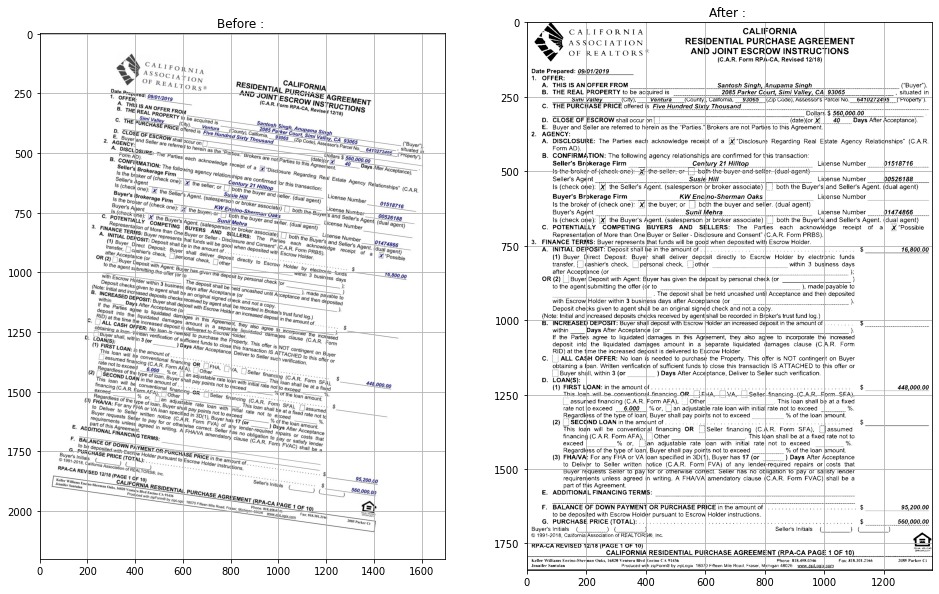

['Santosh Singh, Anupama Singh', ' 2085 Parker Court, Simi Valley, CA 93065 ', 'Five Hundred Sixty Thousand', 'KW Encino-Sherman Oaks Sunil Mehra', '01474866 X "Possible', 'To be done', '', 'ssible']
========================================	out1.pdf_right_skewed8.jpg_test.csvfile saved!	========================================


In [0]:
import os
os.getcwd()
path = '/content/drive/My Drive/imagesv2/test'
os.chdir(path)
os.getcwd()
files = [f for f in os.listdir() if f[-4:] == '.jpg']
#print(files)
image_name = 'out1.pdf_right_skewed8.jpg'
os.chdir(path)
    # print(image_name)
    # print(os.getcwd())
image = preprocess(image_name)
os.chdir('/content/drive/My Drive/imagesv2/Dump_output')
cv2.imwrite('output.jpg',image)
image_path = '/content/drive/My Drive/imagesv2/Dump_output/output.jpg'
fields = extract_fields(image_path)
if fields == None:
  print('Skipping this image at present.')
path = '/content/drive/My Drive/imagesv2/'
print(fields)
convert_to_csv(fields,image_name)